In [2]:
import pandas as pd
import sqlite3
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt


In [3]:
orders = pd.read_csv('orders.csv')
products = pd.read_csv('products.csv')
spend = pd.read_csv('spend.csv')

In [4]:
print(orders.columns)
print(products.columns)
print(spend.columns)

Index(['fulldate', 'order_device_platform', 'country', 'channel',
       'order_id_hashed', 'line_id_hashed', 'product_id_hashed', 'gtv_usd'],
      dtype='object')
Index(['product_id_hashed', 'product_family', 'product_category'], dtype='object')
Index(['fulldate', 'country', 'channel', 'spend_usd'], dtype='object')


In [5]:
products['product_family'].unique()

array(['Boys Accessories', 'Girls Accessories', 'Lingerie & Nightwear',
       'Makeup', 'Accessories', 'Baby Boy Clothing', 'Clothing',
       'Girls Clothing', 'Boys Clothing', 'Baby Girl Clothing',
       'Teen Boy Clothing', 'Shoes', 'Girls Shoes', 'Jewellery',
       'Underwear & Socks', 'Bags', 'Fragrance', 'Boys Shoes',
       'Baby Girl Shoes', 'Activewear', 'Baby Boy Shoes', 'Homeware',
       'Teen Girl Clothing', 'Hair', 'Teen Girl Shoes', 'Nursery',
       'Teen Boy Shoes', 'Fine Jewellery', 'Pre-Owned',
       'Baby Girl Accessories', 'Watches', 'Bath and Body', 'Skincare',
       'Demi-Fine Jewellery', 'Teen Girl Accessories',
       'Teen Boy Accessories', 'Baby Boy Accessories', 'N/D'],
      dtype=object)

In [6]:
# Create a connection to an in-memory SQLite
conn = sqlite3.connect(':memory:')

# Write the DataFrame to a SQL table  
orders.to_sql('orders', conn, index=False, if_exists='replace')
products.to_sql('products', conn, index=False, if_exists='replace')
spend.to_sql('spend', conn, index=False, if_exists='replace')

1200

In [7]:
query1 = """

select channel, sum(spend_usd) from 
(select *
from orders o
join spend s
on o.fulldate = s.fulldate and o.country = s.country and o.channel = s.channel

group by 1 )
group by 1
order by 2 desc

 """

# Execute the query
result_query1 = pd.read_sql_query(query1, conn)

# Display the result
print(result_query1)


        channel  sum(spend_usd)
0           ppc   628999.027417
1       display    66352.868244
2    affiliates    32649.445534
3  partnerships    13068.724873


In [10]:
cross_cat_query =  """

select fulldate,sum(spend_usd) 
from spend
where channel = 'affiliates'
group by 1
order by 2 desc
limit 5


"""

cross_cat_query = pd.read_sql_query(cross_cat_query, conn)

# Display the result
print(cross_cat_query.head(10))



     fulldate  sum(spend_usd)
0  2022-04-26    29331.603353
1  2022-04-07    19661.717680
2  2022-04-11    19308.903815
3  2022-04-05    18675.349553
4  2023-04-18    18067.742076


In [11]:
cross_cat_query =  """
select min(fulldate),max(fulldate) 
from orders
"""
cross_cat_query = pd.read_sql_query(cross_cat_query, conn)

# Display the result
print(cross_cat_query.head(10))


  min(fulldate) max(fulldate)
0    2022-04-01    2023-04-30


In [12]:
cross_cat_query =  """
select country,sum(gtv_usd) as GTV 
from orders
group by 1 
order by 2 desc

"""
cross_cat_query = pd.read_sql_query(cross_cat_query, conn)

# Display the result
print(cross_cat_query.head(10))


          country           GTV
0  United Kingdom  2.198596e+07
1    Saudi Arabia  1.302971e+07
2       Hong Kong  8.636835e+06
3           Italy  8.364235e+06
4          Mexico  8.351140e+06


In [13]:
cross_cat_query =  """

select fulldate,sum(gtv_usd) as GTV from orders group by 1 order by 2 desc limit 5

"""
cross_cat_query = pd.read_sql_query(cross_cat_query, conn)

# Display the result
print(cross_cat_query.head(10))

     fulldate          GTV
0  2023-04-11  1231795.248
1  2023-04-04  1221258.669
2  2022-04-27  1193562.455
3  2023-04-03  1185171.896
4  2022-04-29  1182197.165


### Conversion Funnel Analysis

Steps in Funnel 
1) Marketing Spend
2) Product engagment 
3) Conversion to purchase
4) Revenue Generation


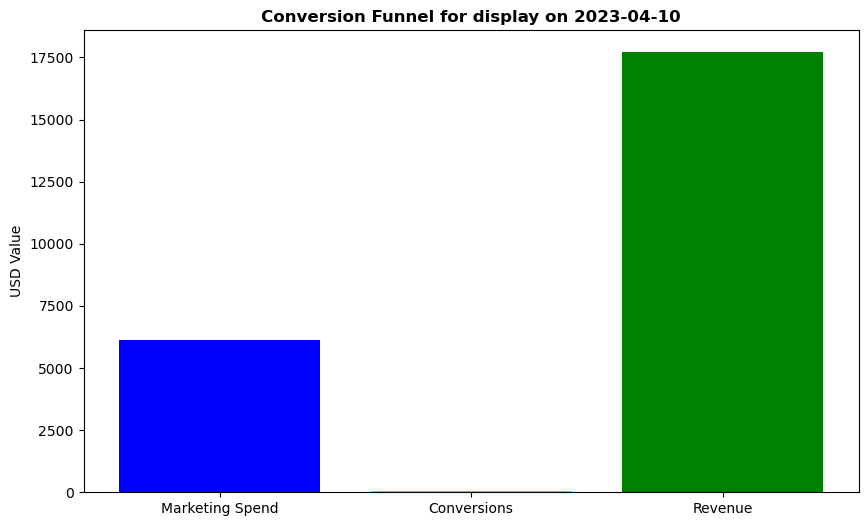

In [20]:

# Step 1: Merge Orders with Products to get product-level details (if needed)
orders_df = orders.merge(products, on='product_id_hashed', how='left')

# Marketing Spend
spend_agg = spend.groupby(['fulldate', 'country', 'channel']).agg({
    'spend_usd': 'sum'
}).reset_index()

# Conversions (Orders)
orders_agg = orders_df.groupby(['fulldate', 'country', 'channel']).agg({
    'order_id_hashed': 'nunique',  # Count of unique orders
    'line_id_hashed': 'nunique',   # Count of unique lines (can be used as engagement)
    'gtv_usd': 'sum'               # Total Gross Transaction Value
}).reset_index()

# Step 3: Merge Metrics for Funnel Analysis
funnel_df = spend.merge(orders_agg, on=['fulldate', 'country', 'channel'], how='left')

# Calculate Conversion Rates
funnel_df['conversion_rate'] = funnel_df['order_id_hashed'] / funnel_df['spend_usd'] * 100
funnel_df['revenue_per_spend'] = funnel_df['gtv_usd'] / funnel_df['spend_usd']

# Step 4: Visualize the Funnel
import matplotlib.pyplot as plt

# Example: Funnel for a specific date and channel
date_filter = '2023-04-10'
channel_filter = 'display'

funnel_data = funnel_df[(funnel_df['fulldate'] == date_filter) & 
                        (funnel_df['channel'] == channel_filter)]

funnel_data.head()

stages = ['Marketing Spend', 'Conversions', 'Revenue']
values = [
    funnel_data['spend_usd'].values[0],
    funnel_data['order_id_hashed'].values[0],
    funnel_data['gtv_usd'].values[0]
]

plt.figure(figsize=(10, 6))
plt.bar(stages, values, color=['blue', 'orange', 'green'])
plt.title(f'Conversion Funnel for {channel_filter} on {date_filter}', weight = 'bold')
plt.ylabel('USD Value')
plt.show()


In [15]:

# Merge orders with product details
orders_df = orders.merge(products, on='product_id_hashed', how='left')

# 1. Analyzing Product Granularity

# Step 1: Number of Products Sold
products_sold = orders_df.groupby('product_id_hashed').agg({
    'line_id_hashed': 'count'  # Number of line items per product
}).rename(columns={'line_id_hashed': 'num_sold'}).reset_index()

print("Number of Products Sold:")
print(products_sold)

# Step 2: Variety of Products Within Orders
order_variety = orders_df.groupby('order_id_hashed').agg({
    'product_id_hashed': 'nunique'  # Unique product count per order
}).rename(columns={'product_id_hashed': 'product_variety'}).reset_index()

print("\nVariety of Products Within Orders:")
print(order_variety)



Number of Products Sold:
         product_id_hashed  num_sold
0     -9223139464337758634         1
1     -9222772326003807323         1
2     -9222625448158817295         1
3     -9222324822265154176         1
4     -9222134348306195081         1
...                    ...       ...
98265  9221892511134835085         1
98266  9221939063548722552         1
98267  9222426251782991386         1
98268  9222641121264549638         9
98269  9222800423397191534         1

[98270 rows x 2 columns]

Variety of Products Within Orders:
            order_id_hashed  product_variety
0      -9223121568386446318                2
1      -9222981623168155010                1
2      -9222866634229994635                3
3      -9222725092060848603                1
4      -9222651747680478542                2
...                     ...              ...
109353  9222664175996560453                1
109354  9222764202479872274                4
109355  9222989565095372681                1
109356  92231042901

In [16]:
# 2. Product-Level Analysis

# Step 1: Contribution to Total Revenue
product_revenue = orders_df.groupby('product_id_hashed').agg({
    'gtv_usd': 'sum'
}).rename(columns={'gtv_usd': 'total_revenue'}).reset_index()

# Calculate percentage contribution to total revenue
total_revenue = product_revenue['total_revenue'].sum()
product_revenue['revenue_contribution_%'] = (product_revenue['total_revenue'] / total_revenue) * 100

print("\nContribution to Total Revenue:")
print(product_revenue)

# Step 2: Customer Behavior Regarding Product Selection
# Most popular products based on number of times sold
popular_products = products_sold.sort_values(by='num_sold', ascending=False)

print("\nMost Popular Products:")
print(popular_products)


Contribution to Total Revenue:
         product_id_hashed  total_revenue  revenue_contribution_%
0     -9223139464337758634        816.309                0.001352
1     -9222772326003807323         32.200                0.000053
2     -9222625448158817295        358.051                0.000593
3     -9222324822265154176        100.733                0.000167
4     -9222134348306195081         80.513                0.000133
...                    ...            ...                     ...
98265  9221892511134835085        825.152                0.001367
98266  9221939063548722552        317.521                0.000526
98267  9222426251782991386        169.384                0.000281
98268  9222641121264549638       6983.132                0.011568
98269  9222800423397191534        733.153                0.001214

[98270 rows x 3 columns]

Most Popular Products:
         product_id_hashed  num_sold
63734  2733697442870675132       597
6117  -8055969962526512088       224
93499  83234467

In [17]:


# Merge orders with product details
orders_df = orders.merge(products, on='product_id_hashed', how='left')

# 1. Analyzing Product Granularity

# Step 1: Number of Products Sold (Grouped by Product and Product Family)
products_sold = orders_df.groupby(['product_id_hashed', 'product_family']).agg({
    'line_id_hashed': 'count'  # Number of line items per product
}).rename(columns={'line_id_hashed': 'num_sold'}).reset_index()

print("Number of Products Sold:")
print(products_sold)

# Step 2: Variety of Products Within Orders (Grouped by Product Family)
order_variety = orders_df.groupby(['order_id_hashed', 'product_family']).agg({
    'product_id_hashed': 'nunique'  # Unique product count per order
}).rename(columns={'product_id_hashed': 'product_variety'}).reset_index()

print("\nVariety of Products Within Orders:")
print(order_variety)



Number of Products Sold:
         product_id_hashed     product_family  num_sold
0     -9223139464337758634           Clothing         1
1     -9222772326003807323  Baby Boy Clothing         1
2     -9222625448158817295           Clothing         1
3     -9222324822265154176     Girls Clothing         1
4     -9222134348306195081           Clothing         1
...                    ...                ...       ...
98265  9221892511134835085              Shoes         1
98266  9221939063548722552               Bags         1
98267  9222426251782991386          Jewellery         1
98268  9222641121264549638           Clothing         9
98269  9222800423397191534              Shoes         1

[98270 rows x 3 columns]

Variety of Products Within Orders:
            order_id_hashed  product_family  product_variety
0      -9223121568386446318   Boys Clothing                2
1      -9222981623168155010            Bags                1
2      -9222866634229994635        Clothing               

In [18]:
# 2. Product-Level Analysis

# Step 1: Contribution to Total Revenue (Grouped by Product and Product Family)
product_revenue = orders_df.groupby(['product_id_hashed', 'product_family']).agg({
    'gtv_usd': 'sum'
}).rename(columns={'gtv_usd': 'total_revenue'}).reset_index()

# Calculate percentage contribution to total revenue
total_revenue = product_revenue['total_revenue'].sum()
product_revenue['revenue_contribution_%'] = (product_revenue['total_revenue'] / total_revenue) * 100

print("\nContribution to Total Revenue:")
print(product_revenue)

# Step 2: Customer Behavior Regarding Product Selection (Grouped by Product Family)
# Most popular products based on number of times sold
popular_products = products_sold.sort_values(by='num_sold', ascending=False)

print("\nMost Popular Products:")
print(popular_products)


Contribution to Total Revenue:
         product_id_hashed     product_family  total_revenue  \
0     -9223139464337758634           Clothing        816.309   
1     -9222772326003807323  Baby Boy Clothing         32.200   
2     -9222625448158817295           Clothing        358.051   
3     -9222324822265154176     Girls Clothing        100.733   
4     -9222134348306195081           Clothing         80.513   
...                    ...                ...            ...   
98265  9221892511134835085              Shoes        825.152   
98266  9221939063548722552               Bags        317.521   
98267  9222426251782991386          Jewellery        169.384   
98268  9222641121264549638           Clothing       6983.132   
98269  9222800423397191534              Shoes        733.153   

       revenue_contribution_%  
0                    0.001352  
1                    0.000053  
2                    0.000593  
3                    0.000167  
4                    0.000133  
...    

## Marginal ROAS Model 

### Logarithmic Modelling

                            OLS Regression Results                            
Dep. Variable:            log_gtv_usd   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     1576.
Date:                Mon, 19 Aug 2024   Prob (F-statistic):          5.22e-121
Time:                        17:45:47   Log-Likelihood:                -61.638
No. Observations:                 300   AIC:                             127.3
Df Residuals:                     298   BIC:                             134.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             4.9349      0.135     36.553

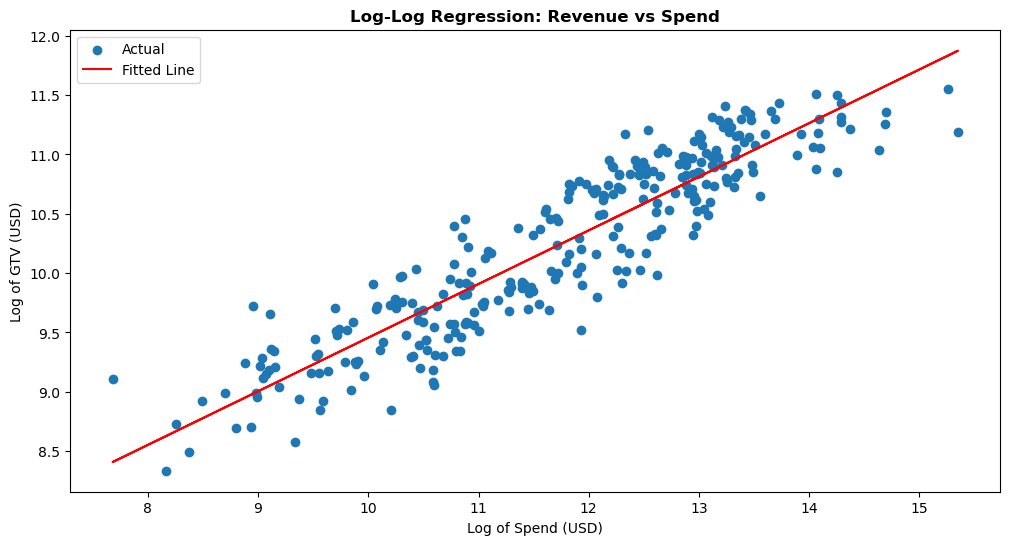

In [28]:

# Merge datasets
merged_data = pd.merge(orders, spend, on=['fulldate', 'country', 'channel'], how='left')

# Convert 'fulldate' to datetime
merged_data['fulldate'] = pd.to_datetime(merged_data['fulldate'])

# Sort data by date
merged_data = merged_data.sort_values(by='fulldate')

merged_data = merged_data[merged_data['channel'] == 'affiliates']


# Aggregate data
econometric_data = merged_data.groupby(['fulldate', 'channel','country']).agg({
    'gtv_usd': 'sum',
    'spend_usd': 'sum'
}).reset_index()

# Apply log transformation to the dependent and independent variables
econometric_data['log_gtv_usd'] = np.log(econometric_data['gtv_usd'])
econometric_data['log_spend_usd'] = np.log(econometric_data['spend_usd'])

# Prepare data for regression
X = econometric_data[['log_spend_usd']]
y = econometric_data['log_gtv_usd']
X = sm.add_constant(X)  # Adds a constant term to the predictor

# Fit the model
model = sm.OLS(y, X).fit()
predictions = model.predict(X)

# Print model summary
print(model.summary())

# Visualization
plt.figure(figsize=(12, 6))
plt.scatter(econometric_data['log_spend_usd'], econometric_data['log_gtv_usd'], label='Actual')
plt.plot(econometric_data['log_spend_usd'], predictions, color='red', label='Fitted Line')
plt.title('Log-Log Regression: Revenue vs Spend', weight = 'bold')
plt.xlabel('Log of Spend (USD)')
plt.ylabel('Log of GTV (USD)')
plt.legend()
plt.show()


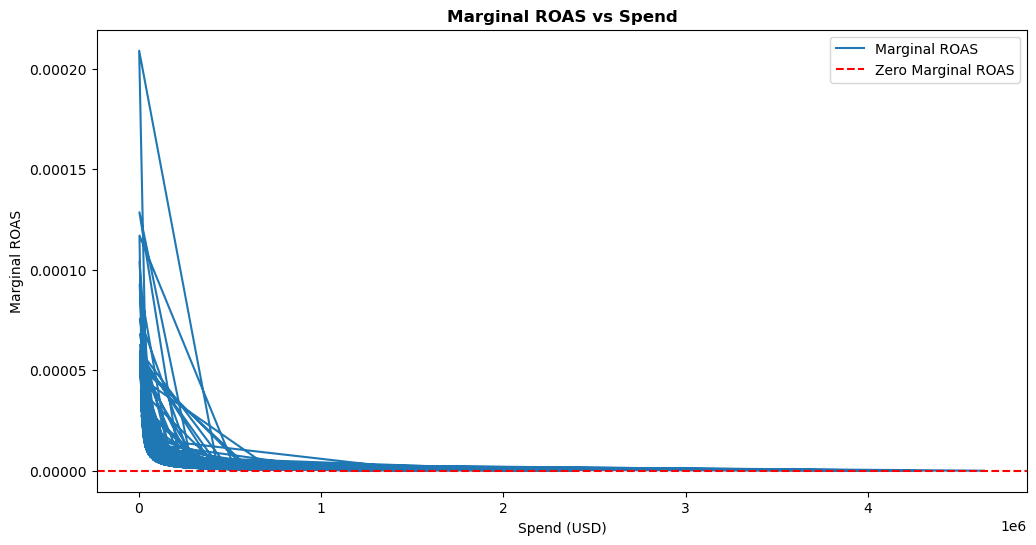

Spend level where Marginal ROAS starts to diminish: 15246.2496


In [29]:


# Assuming econometric_data is already prepared as in your code snippet

# Extract the coefficient for log_spend_usd
coefficient = model.params['log_spend_usd']

# Calculate Marginal ROAS for a range of spend values
econometric_data['marginal_roas'] = coefficient / econometric_data['spend_usd']

# Determine the spend level where Marginal ROAS starts to flatten or diminish
econometric_data['change_in_marginal_roas'] = econometric_data['marginal_roas'].diff()

# Visualization: Plot Marginal ROAS vs Spend
plt.figure(figsize=(12, 6))
plt.plot(econometric_data['spend_usd'], econometric_data['marginal_roas'], label='Marginal ROAS')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Marginal ROAS')
plt.title('Marginal ROAS vs Spend', weight = 'bold')
plt.xlabel('Spend (USD)')
plt.ylabel('Marginal ROAS')
plt.legend()
plt.show()

# Determine the point where Marginal ROAS starts to diminish significantly
diminishing_point = econometric_data.loc[econometric_data['change_in_marginal_roas'] < 0, 'spend_usd'].min()
print(f"Spend level where Marginal ROAS starts to diminish: {diminishing_point}")


In [32]:
import numpy as np

# Calculate the covariance matrix
cov_matrix = np.cov(econometric_data[['log_gtv_usd', 'log_spend_usd']].T)

# Print the covariance matrix
print("Covariance Matrix:")
print(cov_matrix)


Covariance Matrix:
[[0.33031855 0.53520187]
 [0.53520187 0.99423243]]


### Incremental Methodology

#### Time based splitting of test and control groups

Incremental ROAS (Time-Based Split): 0.00598650288518838


/tmp/ipykernel_680/1805633651.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='group', y='gtv_usd', data=group_performance, palette='viridis')


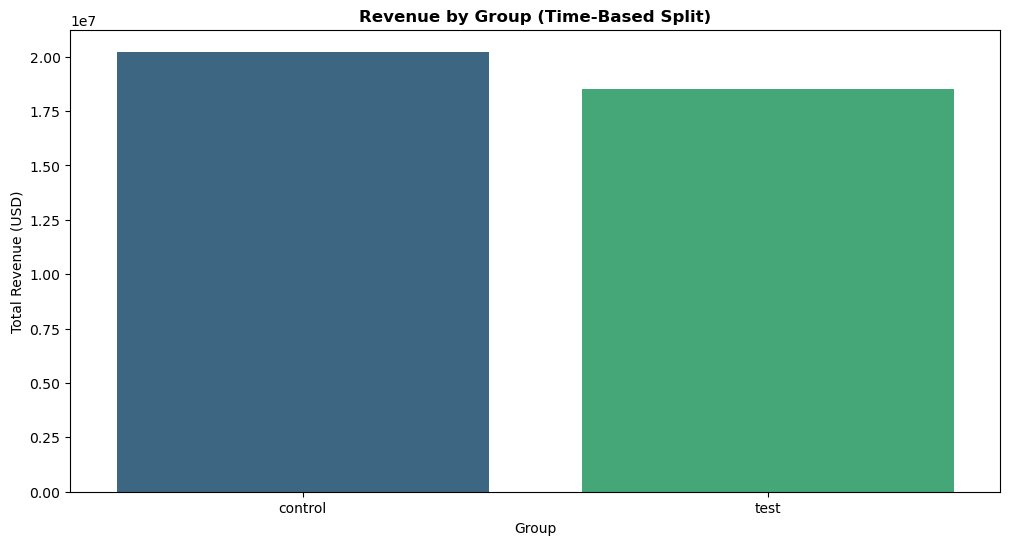

/tmp/ipykernel_680/1805633651.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='group', y='spend_usd', data=group_performance, palette='viridis')


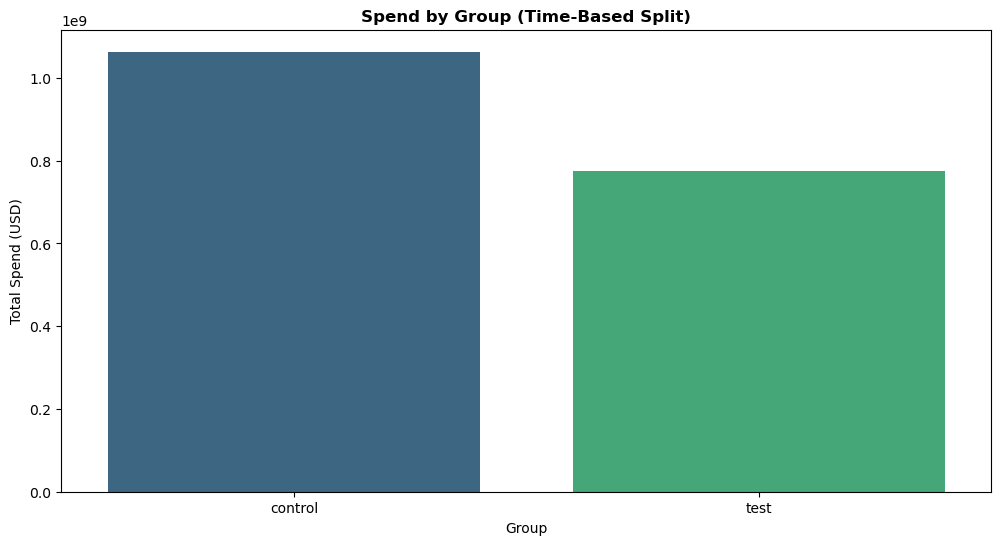

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sample data loading
orders = pd.read_csv('orders.csv')
spend = pd.read_csv('spend.csv')

# Merge datasets
merged_data = pd.merge(orders, spend, on=['fulldate', 'country', 'channel'], how='left')

# Convert 'fulldate' to datetime
merged_data['fulldate'] = pd.to_datetime(merged_data['fulldate'])

# Sort data by date
merged_data = merged_data.sort_values(by='fulldate')

merged_data = merged_data[merged_data['channel'] == 'ppc']

# Define split date (e.g., median date)
split_date = merged_data['fulldate'].median()


# Create 'group' column based on split date
merged_data['group'] = merged_data['fulldate'].apply(lambda x: 'test' if x > split_date else 'control')

# Aggregate data for test and control groups
group_performance = merged_data.groupby(['group']).agg({
    'gtv_usd': 'sum',
    'spend_usd': 'sum'
}).reset_index()

# Calculate incremental metrics
test_group = group_performance[group_performance['group'] == 'test']
control_group = group_performance[group_performance['group'] == 'control']

incremental_revenue = test_group['gtv_usd'].values[0] - control_group['gtv_usd'].values[0]
incremental_spend = test_group['spend_usd'].values[0] - control_group['spend_usd'].values[0]

# Calculate Incremental ROAS
incremental_roas = incremental_revenue / incremental_spend
print(f'Incremental ROAS (Time-Based Split): {incremental_roas}')

# Visualization
plt.figure(figsize=(12, 6))
sns.barplot(x='group', y='gtv_usd', data=group_performance, palette='viridis')
plt.title('Revenue by Group (Time-Based Split)', weight = 'bold')
plt.xlabel('Group')
plt.ylabel('Total Revenue (USD)')
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x='group', y='spend_usd', data=group_performance, palette='viridis')
plt.title('Spend by Group (Time-Based Split)', weight = 'bold')
plt.xlabel('Group')
plt.ylabel('Total Spend (USD)')
plt.show()


Incremental ROAS (Geographical Split): 0.011110232450907306


/tmp/ipykernel_680/2926177069.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='group', y='gtv_usd', data=group_performance, palette='viridis')


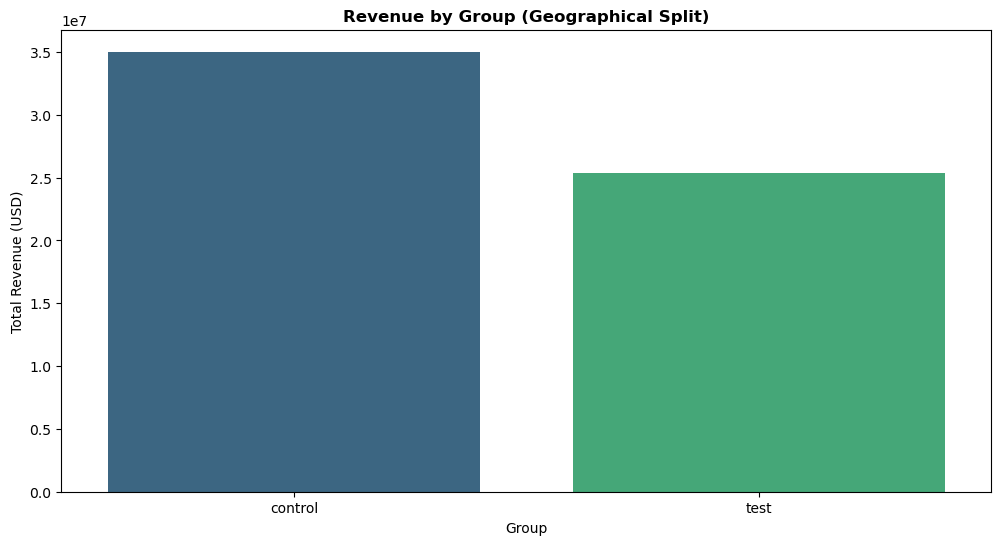

/tmp/ipykernel_680/2926177069.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='group', y='spend_usd', data=group_performance, palette='viridis')


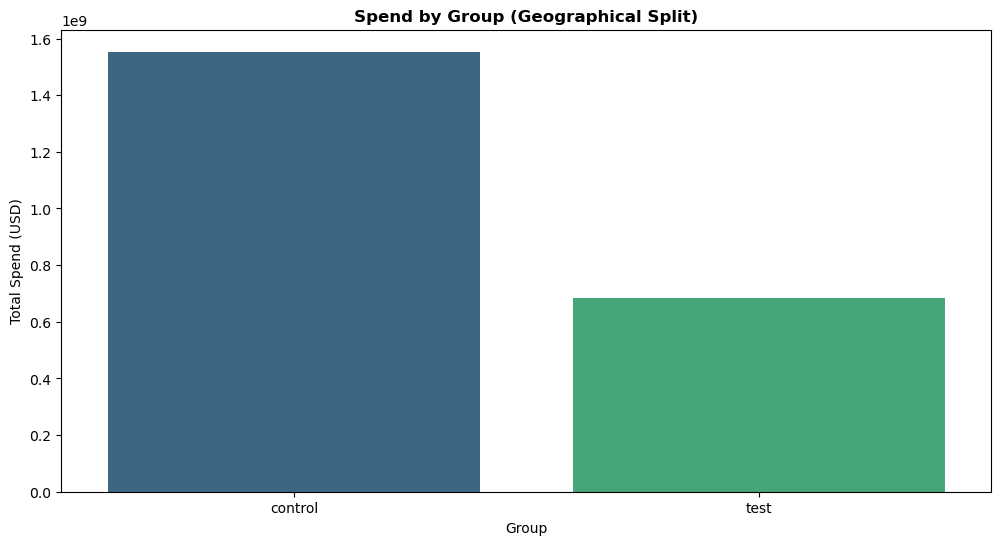

In [32]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Sample data loading
orders = pd.read_csv('orders.csv')
spend = pd.read_csv('spend.csv')

# Merge datasets
merged_data = pd.merge(orders, spend, on=['fulldate', 'country', 'channel'], how='left')

# Define control and test groups
control_countries = ['United Kingdom', 'Saudi Arabia']
test_countries = [country for country in merged_data['country'].unique() if country not in control_countries]

# Assign groups based on predefined control and test countries
merged_data['group'] = merged_data['country'].apply(lambda x: 'control' if x in control_countries else 'test')

# Aggregate data for test and control groups
group_performance = merged_data.groupby(['group']).agg({
    'gtv_usd': 'sum',
    'spend_usd': 'sum'
}).reset_index()

# Calculate incremental metrics
test_group = group_performance[group_performance['group'] == 'test']
control_group = group_performance[group_performance['group'] == 'control']

incremental_revenue = test_group['gtv_usd'].values[0] - control_group['gtv_usd'].values[0]
incremental_spend = test_group['spend_usd'].values[0] - control_group['spend_usd'].values[0]

# Calculate Incremental ROAS
incremental_roas = incremental_revenue / incremental_spend
print(f'Incremental ROAS (Geographical Split): {incremental_roas}')

# Visualization
plt.figure(figsize=(12, 6))
sns.barplot(x='group', y='gtv_usd', data=group_performance, palette='viridis')
plt.title('Revenue by Group (Geographical Split)', weight = 'bold')
plt.xlabel('Group')
plt.ylabel('Total Revenue (USD)')
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x='group', y='spend_usd', data=group_performance, palette='viridis')
plt.title('Spend by Group (Geographical Split)', weight = 'bold')
plt.xlabel('Group')
plt.ylabel('Total Spend (USD)')
plt.show()


## ----- Market Mix models 

In [33]:
## Data preparation seperately 

In [8]:


# Load the datasets (assuming CSV format)
orders_df = pd.read_csv('orders.csv')
products_df = pd.read_csv('products.csv')
spend_df = pd.read_csv('spend.csv')

# Merge Orders with Products to get product details
orders_products_df = pd.merge(orders_df, products_df, on='product_id_hashed', how='left')

# Aggregate Orders to get daily Gross Transaction Value (GTV) by date, country, and channel
orders_agg_df = orders_products_df.groupby(['fulldate', 'country', 'channel'])['gtv_usd'].sum().reset_index()

# Merge Orders with Spend to get the daily spend data
merged_df = pd.merge(orders_agg_df, spend_df, on=['fulldate', 'country', 'channel'], how='left')

# Convert 'fulldate' to datetime format
merged_df['fulldate'] = pd.to_datetime(merged_df['fulldate'])

# Sort by date
merged_df = merged_df.sort_values('fulldate')

# Check the final merged dataset
print(merged_df.head())


     fulldate         country       channel     gtv_usd     spend_usd
0  2022-04-01       Hong Kong    affiliates   32710.578   3534.819056
19 2022-04-01  United Kingdom           ppc  300326.731  28065.735668
18 2022-04-01  United Kingdom  partnerships   62755.877   3861.838790
17 2022-04-01  United Kingdom       display   14611.559  15651.052217
16 2022-04-01  United Kingdom    affiliates   82390.410   8523.516666


In [9]:

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import seaborn as sns


# Check for missing values and handle them (e.g., fill with 0 or drop)
merged_df.fillna(0, inplace=True)

# Create features and target variable
# Assuming spend is the sum of spending on different channels
features = merged_df.drop(columns=['fulldate', 'gtv_usd'])
target = merged_df['gtv_usd']

# Encode categorical variables (country, channel)
features = pd.get_dummies(features, columns=['country', 'channel'], drop_first=True)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)


In [10]:
from sklearn.metrics import r2_score

# Initialize the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_train = rf_model.predict(X_train)
y_pred_test = rf_model.predict(X_test)

# Calculate R-squared for training data
r2_train = r2_score(y_train, y_pred_train)

# Calculate R-squared for test data
r2_test = r2_score(y_test, y_pred_test)

print(f'Train R-squared: {r2_train}')
print(f'Test R-squared: {r2_test}')


Train R-squared: 0.9853913216395329
Test R-squared: 0.8727509866419548


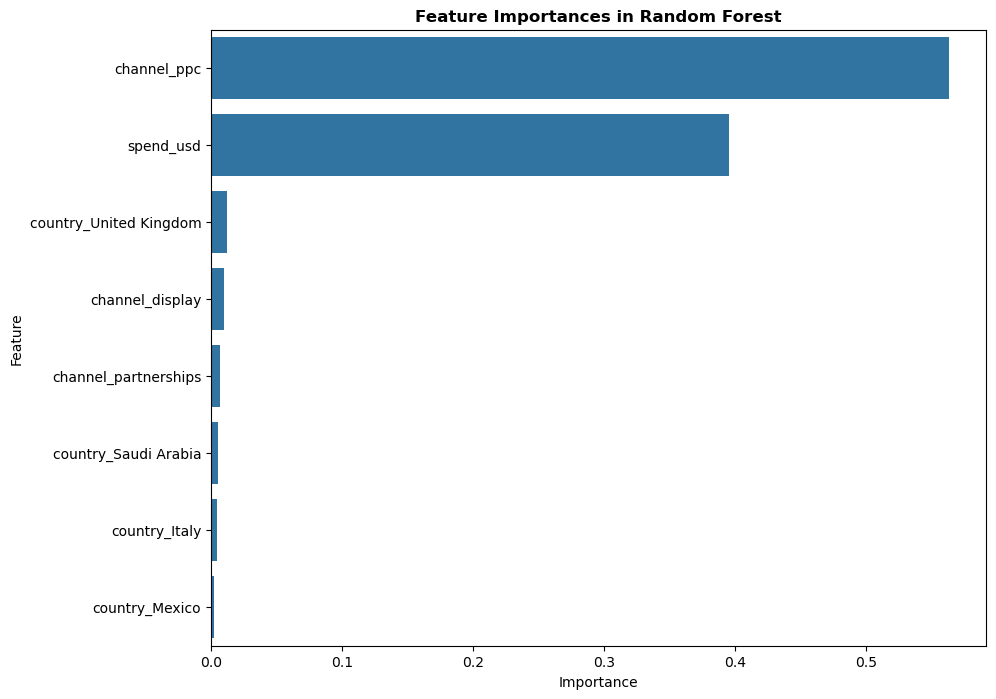

In [11]:
# Get feature importances
importances = rf_model.feature_importances_
feature_names = X_train.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort by importance
importance_df = importance_df.sort_values('Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances in Random Forest', weight = 'bold')
plt.show()


/tmp/ipykernel_100/2625629273.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='gtv_usd', y='channel', data=channel_efficiency_df, palette='coolwarm')


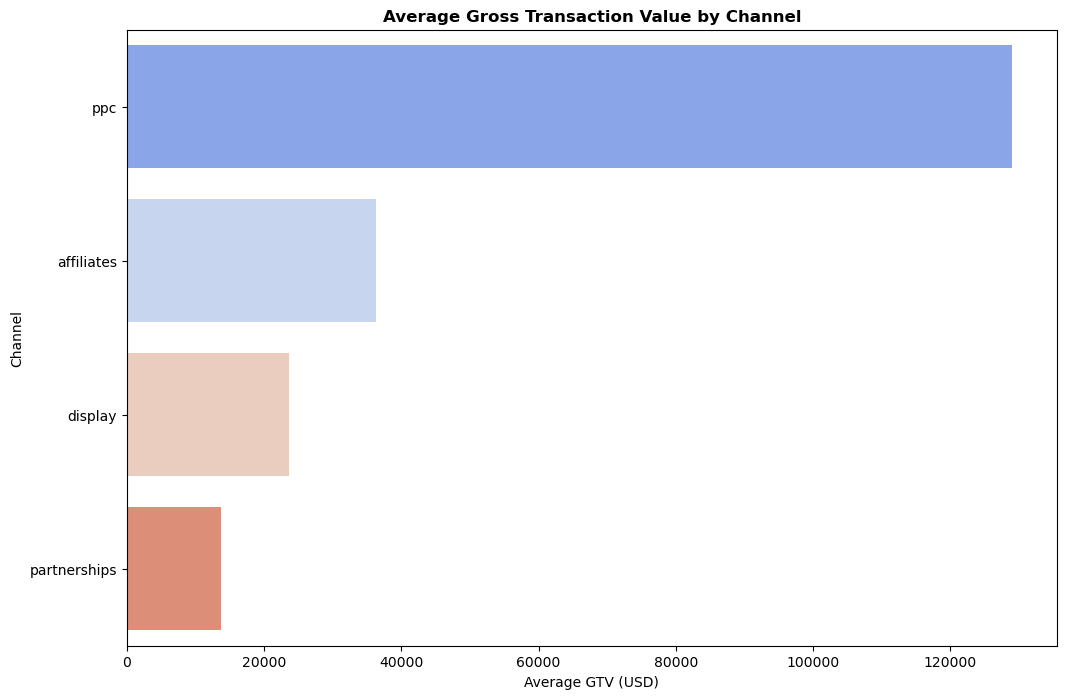

        channel        gtv_usd
3           ppc  129071.919397
0    affiliates   36302.170403
1       display   23578.218767
2  partnerships   13790.971809


In [12]:
# Aggregate GTV by channel
channel_efficiency_df = merged_df.groupby('channel')['gtv_usd'].mean().reset_index()

# Sort by GTV
channel_efficiency_df = channel_efficiency_df.sort_values(by='gtv_usd', ascending=False)

# Plot channel efficiency
plt.figure(figsize=(12, 8))
sns.barplot(x='gtv_usd', y='channel', data=channel_efficiency_df, palette='coolwarm')
plt.title('Average Gross Transaction Value by Channel', weight = 'bold')
plt.xlabel('Average GTV (USD)')
plt.ylabel('Channel')
plt.show()

# Print average GTV by channel
print(channel_efficiency_df)


/tmp/ipykernel_100/3028976095.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='ROI', y='channel', data=roi_df, palette='viridis')


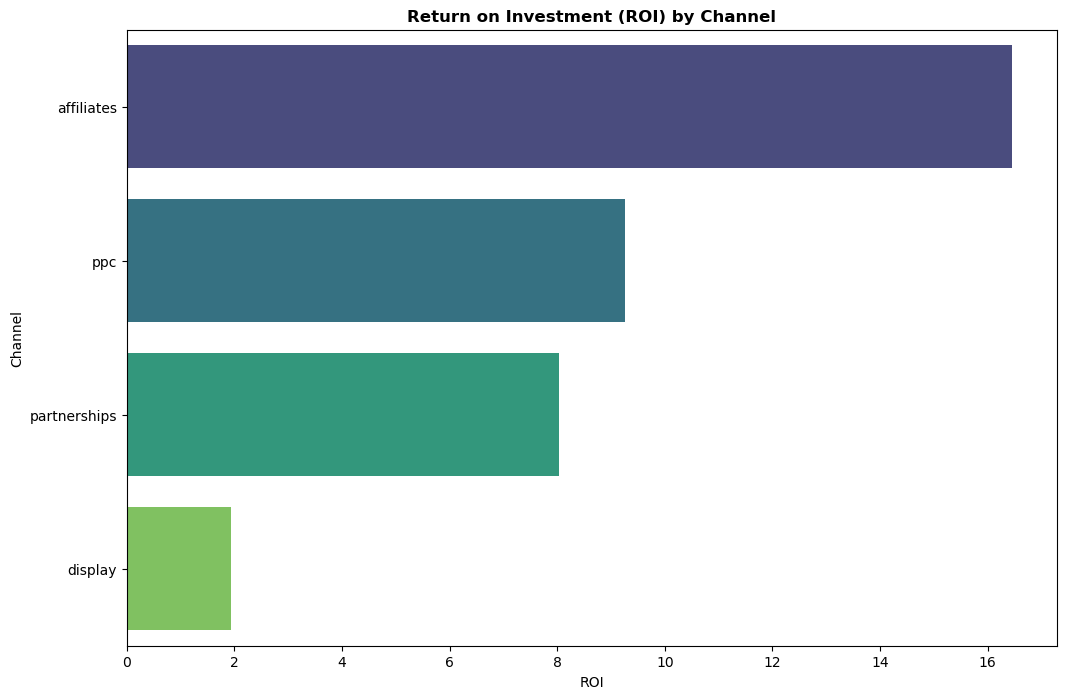

        channel   Total Spend     Total GTV        ROI
0    affiliates  6.616110e+05  1.089065e+07  16.460808
3           ppc  4.185835e+06  3.872158e+07   9.250621
2  partnerships  4.583946e+05  3.682189e+06   8.032795
1       display  3.639490e+06  7.073466e+06   1.943532


In [13]:

# Assuming you have data on spend and GTV by channel
roi_df = merged_df.groupby('channel').apply(
    lambda x: pd.Series({
        'Total Spend': x['spend_usd'].sum(),
        'Total GTV': x['gtv_usd'].sum(),
        'ROI': x['gtv_usd'].sum() / x['spend_usd'].sum()
    })
).reset_index()

# Sort by ROI
roi_df = roi_df.sort_values(by='ROI', ascending=False)

# Plot ROI
plt.figure(figsize=(12, 8))
sns.barplot(x='ROI', y='channel', data=roi_df, palette='viridis')
plt.title('Return on Investment (ROI) by Channel', weight = 'bold')
plt.xlabel('ROI')
plt.ylabel('Channel')
plt.show()

# Print ROI values
print(roi_df)


In [14]:
pip install shap

  Using cached shap-0.46.0-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (24 kB)
  Using cached slicer-0.0.8-py3-none-any.whl.metadata (4.0 kB)
Using cached shap-0.46.0-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (540 kB)
Using cached slicer-0.0.8-py3-none-any.whl (15 kB)

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


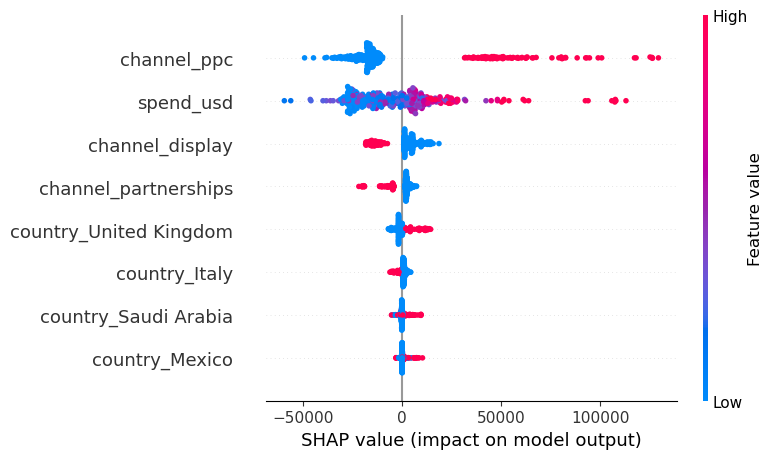

In [15]:
import shap

# Initialize the SHAP explainer
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)

# Plot SHAP values for channels
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)


In [16]:
# Merge Orders with Products to get product family details
orders_products_df = pd.merge(orders_df, products_df[['product_id_hashed', 'product_family']], on='product_id_hashed', how='left')
orders_products_df.head()

,fulldate,order_device_platform,country,channel,order_id_hashed,line_id_hashed,product_id_hashed,gtv_usd,product_family
0,2023-04-09,web,Hong Kong,affiliates,-3982836491986944005,-4272880854253580086,1506064913130599960,51.847,Boys Accessories
1,2023-04-09,app,Mexico,display,-2003073910870235414,1353403971090728739,-5141547415258449446,85.112,Boys Accessories
2,2023-04-09,app,Mexico,ppc,3004713095025632384,5721848311334372207,-1853657496400731429,85.112,Boys Accessories
3,2023-04-09,app,Saudi Arabia,ppc,7298690718945651627,1815211757681252216,-8963485786846730437,116.238,Boys Accessories
4,2023-04-09,app,Saudi Arabia,affiliates,8164893762748750865,-1798454132145172102,-5038713400911845474,154.361,Girls Accessories


In [17]:
# Aggregate GTV by product family and channel
product_family_channel_agg_df = orders_products_df.groupby(['product_family', 'channel'])['gtv_usd'].sum().reset_index()

# Sort for better visualization
product_family_channel_agg_df = product_family_channel_agg_df.sort_values(by=['product_family', 'gtv_usd'], ascending=[True, False])


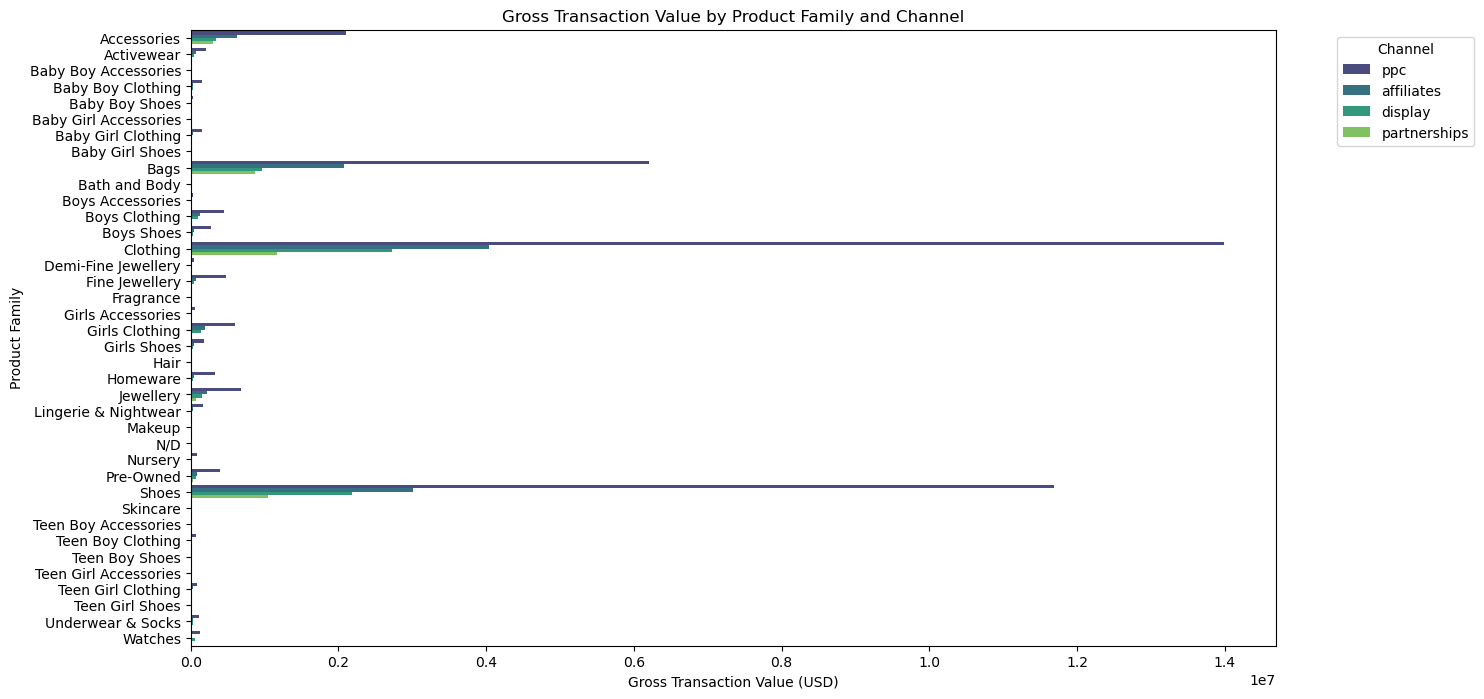

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a horizontal bar plot for GTV by product family and channel
plt.figure(figsize=(14, 8))
sns.barplot(y='product_family', x='gtv_usd', hue='channel', data=product_family_channel_agg_df, palette='viridis')
plt.title('Gross Transaction Value by Product Family and Channel', weight = 'bold')
plt.xlabel('Gross Transaction Value (USD)')
plt.ylabel('Product Family')
plt.legend(title='Channel', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### ------------ Product Recommendation Model

In [1]:
import pandas as pd

# Load datasets
orders = pd.read_csv('orders.csv')
products = pd.read_csv('products.csv')
spend = pd.read_csv('spend.csv')

# Merge datasets
orders_products = orders.merge(products, on='product_id_hashed', how='left')
merged_data = orders_products.merge(spend, on=['fulldate', 'country', 'channel'], how='left')

# Calculate AOV
merged_data['AOV'] = merged_data['gtv_usd'] / merged_data.groupby(['country', 'channel', 'product_family', 'product_category'])['order_id_hashed'].transform('count')

# Aggregate metrics
aggregated = merged_data.groupby(['country', 'channel', 'product_family', 'product_category']).agg({
    'gtv_usd': 'sum',
    'spend_usd': 'sum',
    'order_id_hashed': 'count',
    'AOV': 'mean'
}).reset_index()

# Calculate the score (sales based ranking)
aggregated['score'] = (0.5 * aggregated['gtv_usd']) + (0.3 * aggregated['AOV']) - (0.2 * aggregated['spend_usd'])

# Rank products
aggregated['rank_family'] = aggregated.groupby(['country', 'channel'])['score'].rank(method='first', ascending=False)
aggregated['rank_category'] = aggregated.groupby(['country', 'channel', 'product_category'])['score'].rank(method='first', ascending=False)

# Get top 5 product families and categories
top_families = aggregated[aggregated['rank_family'] <= 5].sort_values(['country', 'channel', 'rank_family'])
top_categories = aggregated[aggregated['rank_category'] <= 5].sort_values(['country', 'channel', 'rank_category'])

# Final Output
final_output = top_families[['country', 'channel', 'product_family', 'rank_family']].merge(
    top_categories[['country', 'channel', 'product_category', 'rank_category']],
    on=['country', 'channel'], how='outer'
).sort_values(['country', 'channel'])

print(final_output)


              country     channel product_family  rank_family  \
0           Hong Kong  affiliates       Clothing          1.0   
1           Hong Kong  affiliates       Clothing          1.0   
2           Hong Kong  affiliates       Clothing          1.0   
3           Hong Kong  affiliates       Clothing          1.0   
4           Hong Kong  affiliates       Clothing          1.0   
...               ...         ...            ...          ...   
17020  United Kingdom         ppc       Skincare          5.0   
17021  United Kingdom         ppc       Skincare          5.0   
17022  United Kingdom         ppc       Skincare          5.0   
17023  United Kingdom         ppc       Skincare          5.0   
17024  United Kingdom         ppc       Skincare          5.0   

       product_category  rank_category  
0                 Belts            1.0  
1             Cufflinks            1.0  
2            Face Masks            1.0  
3      Glasses & Frames            1.0  
4             

In [19]:
filtered_df = final_output[(final_output['channel'] == 'ppc') & (final_output['rank_family'] == 5)]
k = filtered_df['product_family'].to_list()
print(list(set(k)))

filtered_df1 = final_output[(final_output['channel'] == 'affiliates') & (final_output['rank_family'] == 5)]
k1 = filtered_df1['product_family'].to_list()
print(list(set(k1)))



['Activewear', 'Baby Girl Shoes', 'Teen Girl Accessories', 'Pre-Owned', 'Skincare']
['Bags', 'Clothing', 'Pre-Owned', 'Fine Jewellery']


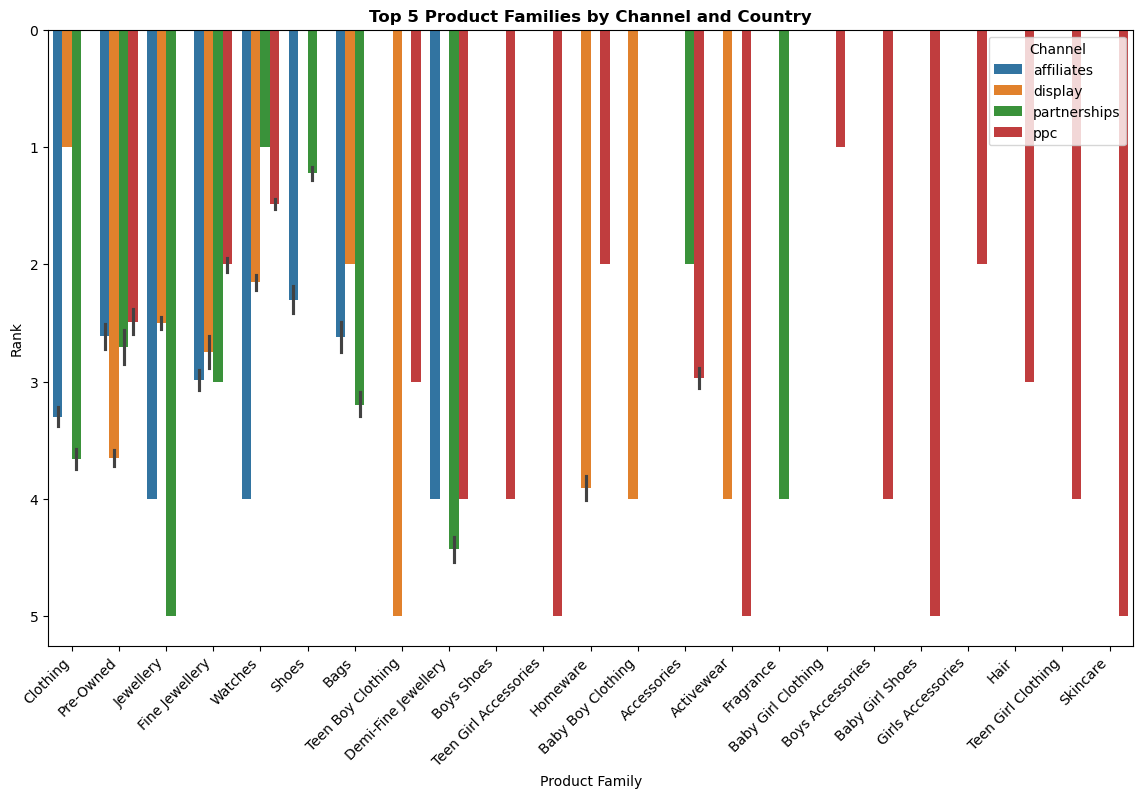

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'final_output' DataFrame from the previous example

# Filter the top 5 product families for visualization
top_families = final_output.dropna(subset=['product_family'])

# Create a bar plot for the top product families
plt.figure(figsize=(14, 8))
sns.barplot(
    x='product_family', 
    y='rank_family', 
    hue='channel', 
    data=top_families,
    dodge=True
)

plt.title('Top 5 Product Families by Channel and Country', weight = 'bold')
plt.xlabel('Product Family')
plt.ylabel('Rank')
plt.gca().invert_yaxis()  # Invert y-axis to show rank 1 at the top
plt.xticks(rotation=45, ha='right')
plt.legend(title='Channel', loc='upper right')
plt.show()


In [30]:
orders_products_agg_df.head()

,fulldate,order_device_platform,country,channel,order_id_hashed,line_id_hashed,product_id_hashed,gtv_usd,product_family_x,product_family_y,month
0,2023-04-09,web,Hong Kong,affiliates,-3982836491986944005,-4272880854253580086,1506064913130599960,51.847,Boys Accessories,Boys Accessories,4
1,2023-04-09,app,Mexico,display,-2003073910870235414,1353403971090728739,-5141547415258449446,85.112,Boys Accessories,Boys Accessories,4
2,2023-04-09,app,Mexico,ppc,3004713095025632384,5721848311334372207,-1853657496400731429,85.112,Boys Accessories,Boys Accessories,4
3,2023-04-09,app,Saudi Arabia,ppc,7298690718945651627,1815211757681252216,-8963485786846730437,116.238,Boys Accessories,Boys Accessories,4
4,2023-04-09,app,Saudi Arabia,affiliates,8164893762748750865,-1798454132145172102,-5038713400911845474,154.361,Girls Accessories,Girls Accessories,4


In [36]:
# Ensure 'fulldate' is in datetime format

orders_products_df['fulldate'] = pd.to_datetime(orders_products_df['fulldate'])

# Extract month from the date for seasonal analysis
orders_products_df['month'] = orders_products_df['fulldate'].dt.month
orders_products_df['fulldate']

0        2023-04-09
1        2023-04-09
2        2023-04-09
3        2023-04-09
4        2023-04-09
            ...    
168526   2023-04-08
168527   2023-04-08
168528   2023-04-08
168529   2023-04-08
168530   2023-04-08
Name: fulldate, Length: 168531, dtype: datetime64[ns]

In [55]:
# Day-wise aggregation SQL query
day_query = '''
    SELECT
        DATE(fulldate) AS day,
        product_family,
        channel,
        SUM(gtv_usd) AS daily_gtv_usd
    FROM orders_products_agg
    where product_family in ('Jewellery','Clothing') and channel in ('ppc', 'partnerships')
    GROUP BY day, product_family, channel
    ORDER BY day;
'''

# Execute the query and load the result into a DataFrame
daily_gtv_df = pd.read_sql_query(day_query, conn)


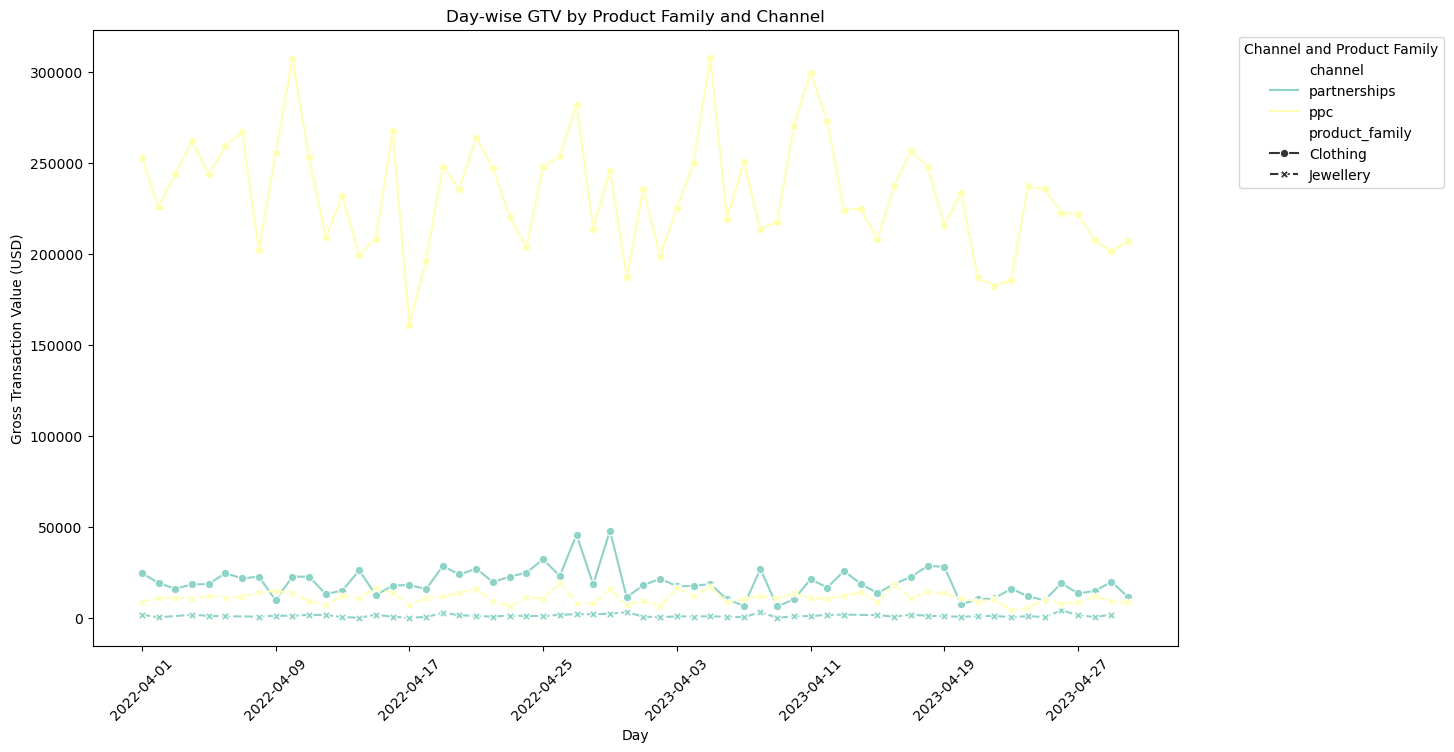

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot day-wise GTV trend
plt.figure(figsize=(14, 8))

# Plot the lineplot
sns.lineplot(x='day', y='daily_gtv_usd', hue='channel', style='product_family', data=daily_gtv_df, markers=True, palette='Set3')

# Set the title and labels
plt.title('Day-wise GTV by Product Family and Channel')
plt.xlabel('Day')
plt.ylabel('Gross Transaction Value (USD)')

# Rotate x-axis labels and show every nth label
plt.xticks(rotation=45, fontsize=10)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))  # Show every 10th label

# Add legend
plt.legend(title='Channel and Product Family', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show plot
plt.show()

